# Compare CCL against benchmarks
This notebook performs comparisons of CCL against our benchmarks for different cosmological quantities. These plots are presented in the CCL paper. Benchmarks are documented in the CCL wiki: https://github.com/LSSTDESC/CCL/wiki/Benchmarks

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
from scipy.interpolate import interp1d
import matplotlib
%matplotlib inline

Set up font sizes, etc.

In [2]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=False)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=16) 

color_map = plt.get_cmap("Dark2")

fig_size = (3.56, 2.2)

## Benchmark cosmologies 
`Cosmology` objects contain the parameters and metadata needed as inputs to most functions. Each `Cosmology` object has a set of cosmological parameters attached to it. In this example, we will only use the parameters of a vanilla LCDM model, but simple extensions (like curvature, neutrino mass, and w0/wa) are also supported.

`Cosmology` objects also contain precomputed data (e.g. splines) to help speed-up certain calculations. As such, `Cosmology` objects are supposed to be immutable; you should create a new `Cosmology` object when you want to change the values of any cosmological parameters.

The cosmologies we are setting up at this stage are documented in the CCL paper, Table 2. With the following plots, we verify the level of accuracy stated in Table 3.

In [3]:
params_ccl1=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, Neff=0)
#Ensure Omega_g and Omega_l have the right values, overwriting fiducials from ccl.Parameters
params_ccl1.parameters.Omega_g =0.
params_ccl1.parameters.Omega_l =0.7
#Only now that parameters are correct we can set up the cosmology
cosmo_ccl1 = ccl.Cosmology(params_ccl1)
params_ccl2=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, Neff=0)
params_ccl2.parameters.Omega_g =0.
params_ccl2.parameters.Omega_l =0.7
cosmo_ccl2 = ccl.Cosmology(params_ccl2)
params_ccl3=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1, Neff=0)
params_ccl3.parameters.Omega_g =0.
params_ccl3.parameters.Omega_l =0.7
cosmo_ccl3 = ccl.Cosmology(params_ccl3)
params_ccl4=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, Omega_k=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1, Neff=0)
params_ccl4.parameters.Omega_g =0.
params_ccl4.parameters.Omega_l =0.65
cosmo_ccl4 = ccl.Cosmology(params_ccl4)
params_ccl5=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, Omega_k=-0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1, Neff=0)
params_ccl5.parameters.Omega_g =0.
params_ccl5.parameters.Omega_l =0.75
cosmo_ccl5 = ccl.Cosmology(params_ccl5)
params_ccl6=ccl.Parameters(Omega_c=0.3, Omega_b=0.0, h=0.7, sigma8 = 0.8, n_s=0.96, Neff=0)
params_ccl6.parameters.Omega_g =0.
params_ccl6.parameters.Omega_n_rel=0.
params_ccl6.parameters.Omega_l =0.7
cosmo_ccl6= ccl.Cosmology(params_ccl6,transfer_function='bbks',matter_power_spectrum='linear')
params_ccl7=ccl.Parameters(Omega_c=0.3, Omega_b=0.0, h=0.7, sigma8 = 0.8, n_s=0.96, Neff=0)
params_ccl7.parameters.Omega_n_rel=0.
params_ccl7.parameters.Omega_l =0.7
cosmo_ccl7= ccl.Cosmology(params_ccl7,transfer_function='bbks',matter_power_spectrum='linear')
cosmo_list=[cosmo_ccl1,cosmo_ccl2,cosmo_ccl3,cosmo_ccl4,cosmo_ccl5,cosmo_ccl6,cosmo_ccl7]
num_models=5
num_models_hiz=3

## Redshift histograms

One of the figures of the paper shows the redshift distributions of two redshift histograms used in the computation of different quantities for the validation of CCL. Here are those two redshift distributions: 

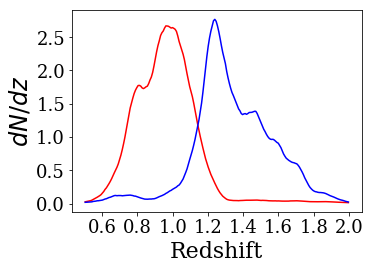

In [7]:
bin_histo1=np.loadtxt('../tests/benchmark/codecomp_step2_outputs/bin1_histo.txt')
bin_histo2=np.loadtxt('../tests/benchmark/codecomp_step2_outputs/bin2_histo.txt')
plt.figure();
plt.gcf().subplots_adjust(left=0.23)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.ylabel(r'$dN/dz$',fontsize=24);
plt.xlabel('Redshift',fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.plot(bin_histo1[:,0],bin_histo1[:,1],'r-')
plt.plot(bin_histo2[:,0],bin_histo2[:,1],'b-')
plt.savefig('dNdz_codecomp.eps');
plt.show();
plt.clf();

## Background functions

### Cosmological Distances

With the cosmologies set up, we will not compute comoving radial distances and compare them to our input benchmark files. First, let's load the benchmark file. The format is: (z,d1,d2,d3,d4,d5) where z is the redshift, d are distances and 1-5 refers to the cosmologies set up above. The units are Mpc/h.

In [4]:
bench=np.loadtxt('../tests/benchmark/chi_model1-5.txt')
z=bench[1:,0]
d_bench=bench[1:,1:]
scale_fact=1./(1+z)

Now let's calculate CCL predictions to compare against the benchmark. Notice CCL returns quantities in units of Mpc.

In [5]:
def compute_ccl_bench_bg(cosmos,a_list,func,h_power=0) :
    o_ccl=np.transpose(np.array([func(c,a_list)*pow(c['h'],h_power) for c in cosmos]))
    return o_ccl
d_ccl=compute_ccl_bench_bg(cosmo_list[:num_models],scale_fact,ccl.comoving_radial_distance,1.)

And we will now make a plot comparing the two quantities.

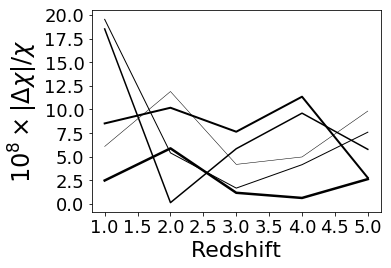

<Figure size 432x288 with 0 Axes>

In [6]:
def plot_ccl_bench_bg(f_bench,f_ccl,z_list,title,tol,figname) :
    plt.figure();
    plt.gcf().subplots_adjust(left=0.23)
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.ylabel(title,fontsize=24);
    plt.xlabel('Redshift',fontsize=22);
    plt.xticks(fontsize=18);
    plt.yticks(fontsize=18);
    for i in range(len(f_bench[0])):
        plt.plot(z_list,np.abs(f_bench[:,i]/f_ccl[:,i]-1)/tol,'k-',lw=i*0.5+0.5);
    plt.savefig(figname+'.eps');
    plt.show();
    plt.clf();
plot_ccl_bench_bg(d_bench,d_ccl,z,r'$10^8\times|\Delta\chi|/\chi$',1E-8,'distances');

### Cosmological distances with massive neutrinos
The above checks distances for cosmologies only without massive neutrinos. We also want to check the distance functionality in cosmologies with massive neutrinos. We use cosmologies very similar to 1-5 above, the only difference being the neutrino parameters and that we don't force Omega_g to 0. Note we set Neff to 3 because we compare to benchmarks calculated using astropy which splits passed neutrinos masses equally amongst the Neff neutrinos.

In [6]:
params_cclmnu1=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, Neff=3, m_nu=[0.04, 0., 0.])
cosmo_cclmnu1 = ccl.Cosmology(params_cclmnu1)
params_cclmnu2=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, Neff=3, m_nu=[0.05, 0.01, 0.])
cosmo_cclmnu2 = ccl.Cosmology(params_cclmnu2)
params_cclmnu3=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1, Neff=3, m_nu=[0.03, 0.02, 0.04])
cosmo_cclmnu3 = ccl.Cosmology(params_cclmnu3)
params_cclmnu4=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, Omega_k=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1, Neff=3, m_nu=[0.05, 0., 0.])
cosmo_cclmnu4 = ccl.Cosmology(params_cclmnu4)
params_cclmnu5=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, Omega_k=-0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1, Neff=3, m_nu=[0.03, 0.02, 0.])
cosmo_cclmnu5 = ccl.Cosmology(params_cclmnu5)

cosmo_mnu_list=[cosmo_cclmnu1,cosmo_cclmnu2,cosmo_cclmnu3,cosmo_cclmnu4,cosmo_cclmnu5]
num_models_mnu = 5;

We load the benchmark file, which has the same format as above.

In [7]:
bench=np.loadtxt('../tests/benchmark/chi_mnu_model1-5.txt')
z_mnu =bench[:,0]
d_bench_mnu =bench[:,1:]
scale_fact_mnu =1./(1+z)

Calculate the distances for cosmologies with massive neutrinos.

In [8]:
d_mnu_ccl=compute_ccl_bench_bg(cosmo_mnu_list[:num_models_mnu],scale_fact_mnu,ccl.comoving_radial_distance)

Plot the discrepancy between benchmarks and ccl. Note that in this case we have a tolerance of $10^{-3}$, because we compare with benchmarks produced by astropy, which uses a fitting formula for the neutrino phasespace integral, which itself differs from the exact expression at greater than a 1.0e-4 level. 

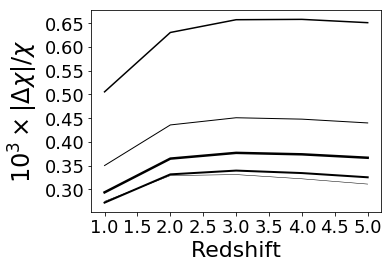

<Figure size 432x288 with 0 Axes>

In [9]:
plot_ccl_bench_bg(d_bench_mnu,d_mnu_ccl,z_mnu,r'$10^3\times|\Delta\chi|/\chi$',1E-3,'distances_nu');

### Cosmological distances (high z)

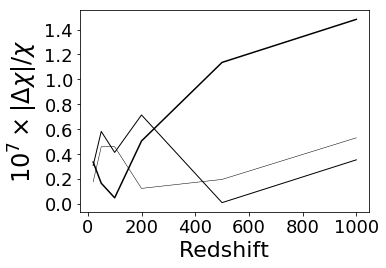

<Figure size 432x288 with 0 Axes>

In [10]:
bench=np.loadtxt('../tests/benchmark/chi_hiz_model1-3.txt')
z=bench[1:,0]
d_hiz_bench=bench[1:,1:]
scale_fact=1./(1+z)
d_hiz_ccl=compute_ccl_bench_bg(cosmo_list[:num_models_hiz],scale_fact,ccl.comoving_radial_distance,1.)
plot_ccl_bench_bg(d_hiz_bench,d_hiz_ccl,z,r'$10^7\times|\Delta\chi|/\chi$',1E-7,'distances_hiz')

### Cosmological distances (high z, with massive neutrinos)
Similarly to above, we only require $10^{-3}$ accuracy here because we compare to benchmarks from astropy, which uses a fitting function for the phase space neutrino integral which itself differs from the exact value at greater than the $10^{-4}$ level.

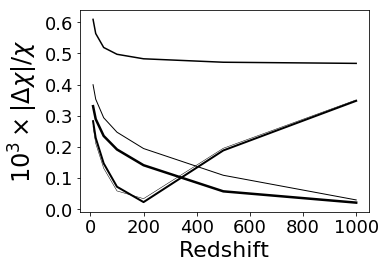

<Figure size 432x288 with 0 Axes>

In [11]:
bench=np.loadtxt('../tests/benchmark/chi_hiz_mnu_model1-5.txt')
z_mnu=bench[:,0]
d_hiz_mnu_bench=bench[:,1:]
scale_fact_mnu=1./(1+z_mnu)
d_hiz_mnu_ccl=compute_ccl_bench_bg(cosmo_mnu_list[:num_models_mnu],scale_fact_mnu,ccl.comoving_radial_distance,0.)
plot_ccl_bench_bg(d_hiz_mnu_bench,d_hiz_mnu_ccl,z_mnu,r'$10^3\times|\Delta\chi|/\chi$',1E-3,'distances_nu_hiz')

### Growth function (low z)

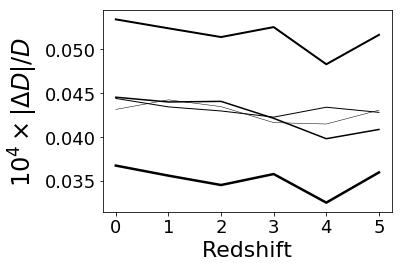

<Figure size 432x288 with 0 Axes>

In [7]:
bench=np.loadtxt('../tests/benchmark/growth_model1-5.txt')
z=bench[:,0]
g_bench=bench[0:,1:]
scale_fact=1./(1+z)
g_ccl=compute_ccl_bench_bg(cosmo_list[:num_models],scale_fact,ccl.growth_factor_unnorm,0.)
plot_ccl_bench_bg(g_bench,g_ccl,z,r'$10^4\times|\Delta D|/D$',1E-4,'growth')

### Growth function (high z)

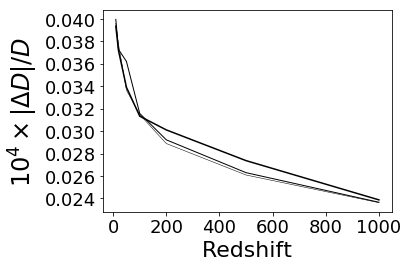

<Figure size 432x288 with 0 Axes>

In [13]:
bench=np.loadtxt('../tests/benchmark/growth_hiz_model1-3.txt')
z=bench[0:,0]
num_z = np.shape(bench)[0]
g_hiz_bench=bench[0:,1:]
scale_fact=1./(1+z)
bench=np.loadtxt('../tests/benchmark/growth_model1-5.txt')
g_hiz_ccl=compute_ccl_bench_bg(cosmo_list[:num_models_hiz],scale_fact,ccl.growth_factor_unnorm,0.)
plot_ccl_bench_bg(g_hiz_bench,g_hiz_ccl,z,r'$10^4\times|\Delta D|/D$',1E-4,'growth_hiz')

## New background benchmark plots

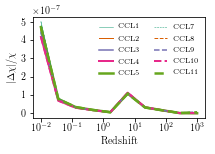

<Figure size 432x288 with 0 Axes>

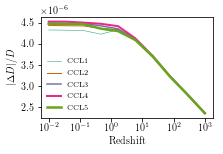

<Figure size 432x288 with 0 Axes>

In [49]:
def plot_ccl_bench_bg_new(f_bench, f_ccl, z_list, title, figname, labels):
    plt.figure(figsize=fig_size)
    plt.gcf().subplots_adjust(left=0.23)
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.ylabel(title)
    plt.xlabel('Redshift')
    if isinstance(f_bench, list):
        # Inlcude massive neutrinos on the same plot
        for i in range(len(f_bench[0][0])):
            plt.plot(z_list, np.abs(f_bench[0][:,i]/f_ccl[0][:,i]-1), 
                     ls='-', c=color_map(i), lw=i*0.5+0.5, label=labels[0][i])
        for i in range(len(f_bench[0][0])):
            plt.plot(z_list, np.abs(f_bench[1][:,i]/f_ccl[1][:,i]-1), 
                     ls='--', c=color_map(i), lw=i*0.5+0.5, label=labels[1][i])
        plt.legend(ncol=2, frameon=False, fontsize="x-small")
    else:    
        for i in range(len(f_bench[0])):
            plt.plot(z_list,np.abs(f_bench[:,i]/f_ccl[:,i]-1),
                     ls='-', c=color_map(i), lw=i*0.5+0.5, label=labels[i])
        plt.legend(frameon=False, fontsize="x-small")
    plt.xscale("log")
    plt.locator_params(axis="x", numticks=6)
    plt.locator_params(axis="y", nbins=6)
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
#     plt.gca().yaxis.offsetText.set_fontsize(18)
    plt.savefig(figname+'.eps')
    plt.show()
    plt.clf()
    
def Neff_from_N_ur_N_ncdm(N_ur, N_ncdm):
    """Calculate N_eff from the number of relativistic and massive neutrinos."""
    Neff = N_ur + N_ncdm * ccl.ccllib.TNCDM**4 / (4./11.)**(4./3.)
    return Neff

def compute_distance(z, Omega_k=0.0, Omega_c=0.25, Omega_b=0.05,
                     h=0.7, sigma8=0.8, n_s=0.96,
                     Neff=3.0, m_nu=0.0, w0=-1.0, wa=0.0):
    # Create new Parameters and Cosmology objects
    p = ccl.Parameters(Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff, 
                       h=h, sigma8=sigma8, n_s=n_s, Omega_k=Omega_k, m_nu=m_nu,
                       w0=w0, wa=wa)    
    cosmo = ccl.Cosmology(p)
    
    a = 1. / (1. + z)
    chi = ccl.comoving_radial_distance(cosmo, a)
    return chi

def compute_growth(z, Omega_k=0.0, Omega_c=0.25, Omega_b=0.05,
                   h=0.7, sigma8=0.8, n_s=0.96,
                   Neff=3.0, m_nu=0.0, w0=-1.0, wa=0.0):
    # Create new Parameters and Cosmology objects.
    # The code that is used for the benchmark (CosmoMAD) does not include the radiation terms.
    # For consistency, we set them to zero and reset Omege_l
    p = ccl.Parameters(Omega_c=Omega_c, Omega_b=Omega_b, Neff=0, 
                       h=h, sigma8=sigma8, n_s=n_s, Omega_k=Omega_k, m_nu=m_nu,
                       w0=w0, wa=wa)
    p.parameters.Omega_g = 0
    p.parameters.Omega_l = 0.7 - Omega_k
    cosmo = ccl.Cosmology(p)
    
    a = 1. / (1. + z)
    growth = ccl.growth_factor_unnorm(cosmo, a)
    return growth

common_params = dict(Omega_c=0.25, Omega_b=0.05,
                     h=0.7, sigma8=0.8, n_s=0.96)

# The distance benchmark uses CLASS, which requires a non-zero N_eff.
models =      ({"Omega_k"  : 0.0,
                "Neff"     : 3.046},
               {"Omega_k"  : 0.0,
                "w0"       : -0.9,
                "wa"       : 0.0,
                "Neff"     : 3.046},
               {"Omega_k"  : 0.0,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : 3.046},
               {"Omega_k"  : 0.05,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : 3.046},
               {"Omega_k"  : -0.05,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : 3.046},
              )

mnu_models =  ({"Omega_k"  : 0.0,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=2.0, N_ncdm=1.0),
                "m_nu"     : [0.04, 0.0, 0.0]},
               {"Omega_k"  : 0.0,
                "w0"       : -0.9,
                "wa"       : 0.0,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=1.0, N_ncdm=2.0),
                "m_nu"     : [0.05, 0.01, 0.0]},
               {"Omega_k"  : 0.0,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=0.0, N_ncdm=3.0),
                "m_nu"     : [0.03, 0.02, 0.04]},
               {"Omega_k"  : 0.05,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=2.0, N_ncdm=1.0),
                "m_nu"     : [0.05, 0.0, 0.0]},
               {"Omega_k"  : -0.05,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=1.0, N_ncdm=2.0),
                "m_nu"     : [0.03, 0.02, 0.0]},
              )

benchmark = np.loadtxt("../tests/benchmark/chi_allz_class_CCL1-11.txt")
z = benchmark[:,0]
chi_benchmark = benchmark[:,1:]

chi_ccl = []
chi_mnu_ccl = []

for m in models:
    chi_ccl.append(compute_distance(z, **common_params, **m))
    
for m in mnu_models:
    chi_mnu_ccl.append(compute_distance(z, **common_params, **m))

chi_ccl = np.array(chi_ccl).T
chi_mnu_ccl = np.array(chi_mnu_ccl).T

plot_ccl_bench_bg_new([chi_benchmark[:,:5], chi_benchmark[:,5:]], [chi_ccl, chi_mnu_ccl], z, 
                      r'$|\Delta\chi|/\chi$', "distances", 
                      [["CCL1", "CCL2", "CCL3", "CCL4", "CCL5"], ["CCL7", "CCL8", "CCL9", "CCL10", "CCL11"]])

benchmark = np.loadtxt("../tests/benchmark/growth_allz_cosmomad_ccl1-5.txt")
z = benchmark[:,0]
growth_benchmark = benchmark[:,1:]

growth_ccl = []

for m in models:
    growth_ccl.append(compute_growth(z, **m))
    
growth_ccl = np.array(growth_ccl).T

plot_ccl_bench_bg_new(growth_benchmark, growth_ccl, z, r'$|\Delta D|/D$', "growth", 
                      ["CCL1", "CCL2", "CCL3", "CCL4", "CCL5"])


## Angular power spectra

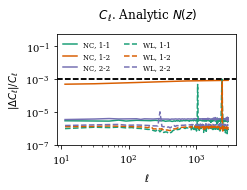

<Figure size 432x288 with 0 Axes>

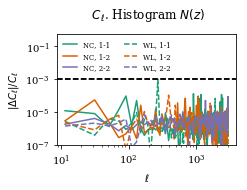

<Figure size 432x288 with 0 Axes>

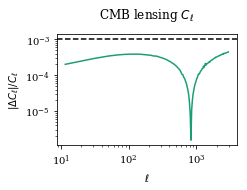

<Figure size 432x288 with 0 Axes>

In [83]:
target_accuracy = 1e-3

#Redshift distribution
zmean1=1.0; zmean2=1.5;
sigz1=0.15; sigz2=0.15;
nzs=512;

z_a_1=np.linspace(zmean1-5*sigz1,zmean1+5*sigz1,nzs);
z_a_2=np.linspace(zmean2-5*sigz2,zmean2+5*sigz2,nzs);
pz_a_1=np.exp(-0.5*((z_a_1-zmean1)/sigz1)**2)
pz_a_2=np.exp(-0.5*((z_a_2-zmean2)/sigz2)**2)
bz_a_1=np.ones_like(z_a_1); bz_a_2=np.ones_like(z_a_2);

z_h_1,pz_h_1=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin1_histo.txt",unpack=True)
z_h_2,pz_h_2=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin2_histo.txt",unpack=True)
bz_h_1=np.ones_like(z_h_1); bz_h_2=np.ones_like(z_h_2);

zarrs={'analytic':{'b1':{'z':z_a_1,'nz':pz_a_1,'bz':bz_a_1},'b2':{'z':z_a_2,'nz':pz_a_2,'bz':bz_a_2}},
      'histo':{'b1':{'z':z_h_1,'nz':pz_h_1,'bz':bz_h_1},'b2':{'z':z_h_2,'nz':pz_h_2,'bz':bz_h_2}}}

#Initialize tracers
cosmo_cls=cosmo_list[-2]
cosmo_cls_cmbl=cosmo_list[-1]
trcrs={}
for nztyp in ['analytic','histo'] :
    trcrs[nztyp]={}
    za=zarrs[nztyp]
    for trtyp in ['dd','ll'] :
        trcrs[nztyp][trtyp]={}
        for bn in ['b1','b2'] :
            if trtyp=='dd' :
                trcrs[nztyp][trtyp][bn]=ccl.ClTracerNumberCounts(cosmo_cls,False,False,
                                                                (za[bn]['z'],za[bn]['nz']),
                                                                (za[bn]['z'],za[bn]['bz']))
            else :
                trcrs[nztyp][trtyp][bn]=ccl.ClTracerLensing(cosmo_cls,False,
                                                            (za[bn]['z'],za[bn]['nz']))
trcrs['cmblens']=ccl.ClTracerCMBLensing(cosmo_cls_cmbl,1100.)

#Read benchmarks
cl_bench={}
for nztyp in ['analytic','histo'] :
    cl_bench[nztyp]={}
    for trtyp in ['dd','ll'] :
        cl_bench[nztyp][trtyp]={}
        for cortyp in ['b1b1','b1b2','b2b2'] :
            cl_bench[nztyp][trtyp][cortyp]={}
            l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_"+cortyp+nztyp+
                            "_log_cl_"+trtyp+".txt",unpack=True)
            cl_bench[nztyp][trtyp][cortyp]['ell']=l.astype(int)
            cl_bench[nztyp][trtyp][cortyp]['cell']=cl
cl_bench['cmblens']={}
l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_log_cl_cc.txt",unpack=True)
cl_bench['cmblens']['ell']=l.astype(int)
cl_bench['cmblens']['cell']=cl
            
#Compute ccl predictions
cl_ccl={}
for nztyp in ['analytic','histo'] :
    cl_ccl[nztyp]={}
    for trtyp in ['dd','ll'] :
        cl_ccl[nztyp][trtyp]={}
        cl_ccl[nztyp][trtyp]['b1b1']={}
        ells=cl_bench[nztyp][trtyp]['b1b1']['ell']
        cfac=np.ones(len(ells))
        if trtyp=='ll' :
            cfac[2:]=ells[2:]*(ells[2:]+1.)/np.sqrt((ells[2:]+2.)*(ells[2:]+1.)*ells[2:]*(ells[2:]-1.))
        cl_ccl[nztyp][trtyp]['b1b1']['ell']=ells
        cl_ccl[nztyp][trtyp]['b1b1']['cell']=ccl.angular_cl(cosmo_cls,trcrs[nztyp][trtyp]['b1'],
                                                            trcrs[nztyp][trtyp]['b1'],ells,dlk=0.01)*cfac**2
        cl_ccl[nztyp][trtyp]['b1b2']={}
        ells=cl_bench[nztyp][trtyp]['b1b2']['ell']
        cfac=np.ones(len(ells))
        if trtyp=='ll' :
            cfac[2:]=ells[2:]*(ells[2:]+1.)/np.sqrt((ells[2:]+2.)*(ells[2:]+1.)*ells[2:]*(ells[2:]-1.))
        cl_ccl[nztyp][trtyp]['b1b2']['ell']=ells
        cl_ccl[nztyp][trtyp]['b1b2']['cell']=ccl.angular_cl(cosmo_cls,trcrs[nztyp][trtyp]['b1'],
                                                            trcrs[nztyp][trtyp]['b2'],ells,dlk=0.01)*cfac**2
        cl_ccl[nztyp][trtyp]['b2b2']={}
        ells=cl_bench[nztyp][trtyp]['b2b2']['ell']
        cfac=np.ones(len(ells))
        if trtyp=='ll' :
            cfac[2:]=ells[2:]*(ells[2:]+1.)/np.sqrt((ells[2:]+2.)*(ells[2:]+1.)*ells[2:]*(ells[2:]-1.))
        cl_ccl[nztyp][trtyp]['b2b2']['ell']=ells
        cl_ccl[nztyp][trtyp]['b2b2']['cell']=ccl.angular_cl(cosmo_cls,trcrs[nztyp][trtyp]['b2'],
                                                            trcrs[nztyp][trtyp]['b2'],ells,dlk=0.01)*cfac**2
cl_ccl['cmblens']={}
cl_ccl['cmblens']['ell']=cl_bench['cmblens']['ell']
cl_ccl['cmblens']['cell']=ccl.angular_cl(cosmo_cls_cmbl,trcrs['cmblens'],trcrs['cmblens'],cl_ccl['cmblens']['ell'],dlk=0.01)

#Plot results
lrange=2980
nrebin=20
names={'analytic':'Analytic','histo':'Histogram','dd':'NC','ll':'WL',
       'b1b1':'1-1','b1b2':'1-2','b2b2':'2-2','cb1b1':'r','cb1b2':'b','cb2b2':'y','cdd':'-','cll':'--'}
for nztyp in ['analytic','histo'] :
    title=r' $C_\ell$. '+names[nztyp]+r' $N(z)$'
    plt.figure(figsize=fig_size)
    plt.title(title)
    plt.gcf().subplots_adjust(left=0.2)
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.ylabel(r'$|\Delta C_\ell|/C_\ell$')
    plt.xlabel(r'$\ell$')
    for trtyp in ['dd','ll'] :
        for i, cortyp in enumerate(['b1b1','b1b2','b2b2']):
            di_bench=cl_bench[nztyp][trtyp][cortyp];
            di_ccl=cl_ccl[nztyp][trtyp][cortyp];
            larr=np.mean(di_bench['ell'][2:2+lrange].astype(float).reshape([lrange//nrebin,nrebin]),axis=1);
            bencharr=np.mean(di_bench['cell'][2:2+lrange].reshape([lrange//nrebin,nrebin]),axis=1);
            cclarr=np.mean(di_ccl['cell'][2:2+lrange].reshape([lrange//nrebin,nrebin]),axis=1);
            plt.plot(larr, np.abs(cclarr/bencharr-1),
                     ls=names['c'+trtyp], c=color_map(i), label=names[trtyp]+', '+names[cortyp]);
        plt.axhline(target_accuracy, c="k", ls="--")
        plt.xscale('log');
        plt.yscale('log');
        plt.ylim(1e-7, 5e-1)
        plt.legend(loc='upper left',ncol=2, frameon=False, fontsize="x-small");
    plt.savefig('Cl_'+nztyp+'.pdf')
    plt.show();
    plt.clf();
    title=names[trtyp]+r' $C_\ell$. '+names[nztyp]+r' $N(z)$'

plt.figure(figsize=fig_size)
plt.title('CMB lensing '+r'$C_\ell$');
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.ylabel(r'$|\Delta C_\ell|/C_\ell$')
plt.xlabel(r'$\ell$')
di_bench=cl_bench['cmblens'];
di_ccl=cl_ccl['cmblens'];
larr=np.mean(di_bench['ell'][2:2+lrange].astype(float).reshape([lrange//nrebin,nrebin]),axis=1);
bencharr=np.mean(di_bench['cell'][2:2+lrange].reshape([lrange//nrebin,nrebin]),axis=1);
cclarr=np.mean(di_ccl['cell'][2:2+lrange].reshape([lrange//nrebin,nrebin]),axis=1);
plt.plot(larr, np.abs(cclarr/bencharr-1), c=color_map(0));
plt.axhline(target_accuracy, c="k", ls="--")
plt.xscale('log');
plt.yscale('log');
plt.savefig('Cl_cmblens.pdf');
plt.show();
plt.clf();


## Non limber (Angpow)

In [63]:
#Redshift distribution
zmean=1.0
sigz=0.02
nzs=1024

z_a=np.linspace(zmean-5*sigz,zmean+5*sigz,nzs);
pz_a=np.exp(-0.5*((z_a-zmean)/sigz)**2)
bz_a=np.ones_like(z_a)

# ell range input
NL = 999
ell_arr = np.arange(2, NL)

# set tracer
nc = ccl.ClTracerNumberCounts(cosmo_ccl6, False, False, n=(z_a,pz_a), bias=(z_a,bz_a))
dchi = (ccl.comoving_radial_distance(cosmo_ccl6,1./(1+z_a[-1]))
        -ccl.comoving_radial_distance(cosmo_ccl6,1./(1+z_a[0])))/500.

In [64]:
limber_cls = ccl.angular_cl(cosmo_ccl6, nc, nc, ell_arr)

In [65]:
native_cls = ccl.angular_cl(cosmo_ccl6, nc, nc, ell_arr, l_limber=NL, 
                            non_limber_method="native", l_linstep=40, l_logstep=1.3,dchi=dchi,dlk=0.003,zmin=0.05)

In [66]:
angpow_cls = ccl.angular_cl(cosmo_ccl6, nc, nc, ell_arr, l_limber=NL,
                            non_limber_method="angpow", l_linstep=40, l_logstep=1.3,dchi=dchi,dlk=0.003,zmin=0.05)

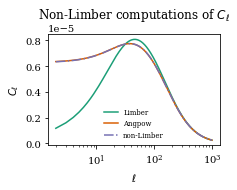

<Figure size 432x288 with 0 Axes>

In [77]:
plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(left=0.23)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.title('Non-Limber computations of '+r'$C_\ell$');
plt.ylabel(r'$C_\ell$')
plt.xlabel(r'$\ell$')
plt.plot(ell_arr,limber_cls, ls='-', color=color_map(0) ,label='Limber');
plt.plot(ell_arr,angpow_cls, ls='-', color=color_map(1),label='Angpow');
plt.plot(ell_arr,native_cls, ls='-.', color=color_map(2),label='non-Limber')
plt.xscale('log');
#plt.ylim([0,1.1])
plt.legend(loc='lower center',frameon=False, fontsize="x-small")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.savefig('angpow1.eps');
plt.show();
plt.clf();

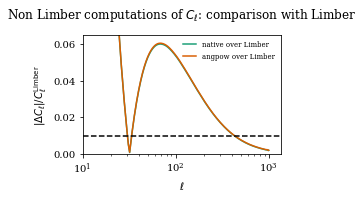

<Figure size 432x288 with 0 Axes>

In [82]:
target_accuracy = 1e-2

plt.figure(figsize=fig_size)
plt.title('Non Limber computations of '+r'$C_\ell$: comparison with Limber');
plt.ylabel(r'$|\Delta C_\ell|/C_\ell^{\mathrm{Limber}}$')
plt.xlabel(r'$\ell$')
plt.plot(ell_arr, np.abs(native_cls/limber_cls-1), c=color_map(0), label='native over Limber');
plt.plot(ell_arr, np.abs(angpow_cls/limber_cls-1), c=color_map(1), label='angpow over Limber');
plt.axhline(target_accuracy, c="k", ls="--")
plt.xscale('log');
plt.ylim([0,6.5e-2])
plt.xlim(xmin=10)
plt.legend(loc='upper right', fontsize="x-small", frameon=False)
plt.savefig('angpow2.eps');
plt.show();
plt.clf();

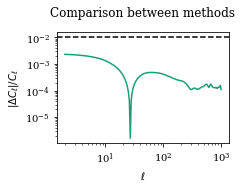

<Figure size 432x288 with 0 Axes>

In [84]:
target_accuracy = 1e-2

plt.figure(figsize=fig_size);
plt.gcf().subplots_adjust(left=0.23)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.title('Comparison between methods');
plt.ylabel(r'$|\Delta C_\ell|/C_\ell$')
plt.xlabel(r'$\ell$')
#plt.plot(ell_arr,200*np.abs(angpow_cls/native_cls-1)/np.sqrt(2./(2*ell_arr+1)),'r-',label='method ratio over cosmic variance');
plt.plot(ell_arr,np.abs(angpow_cls/native_cls-1), c=color_map(0));
plt.axhline(target_accuracy, c="k", ls="--")
plt.xscale('log');
plt.yscale('log');
# plt.ylim([0,1.18])
#plt.legend(loc='upper right',prop={'size':12},frameon=False);
plt.savefig('angpow3.eps');
plt.show();
plt.clf();

## Projected correlation function

In [87]:
#Read benchmarks
bench_err={}
bench_err['dd']=np.genfromtxt("../tests/benchmark/cov_corr/sigma_clustering_Nbin5",names=('theta','b1b1','b2b2','b1b2'))
bench_err['ll+']=np.genfromtxt("../tests/benchmark/cov_corr/sigma_xi+_Nbin5",names=('theta','b1b1','b2b2','b1b2'))
bench_err['ll-']=np.genfromtxt("../tests/benchmark/cov_corr/sigma_xi-_Nbin5",names=('theta','b1b1','b2b2','b1b2'))

corr_bench={}
for nztyp in ['analytic','histo'] :
    corr_bench[nztyp]={}
    for bn in ['b1b1','b2b2'] :
        corr_bench[nztyp][bn]={}
        for trtyp in ['dd','ll'] :
            if  'dd' in trtyp:
                corr_bench[nztyp][bn][trtyp]=np.genfromtxt("../tests/benchmark/codecomp_step2_outputs/run_"+bn+nztyp+"_log_wt_"+trtyp+".txt",names=('theta','xi'))
            else:
                corr_bench[nztyp][bn][trtyp+'+']=np.genfromtxt("../tests/benchmark/codecomp_step2_outputs/run_"+bn+nztyp+"_log_wt_"+trtyp+"_pp.txt",names=('theta','xi'))
                corr_bench[nztyp][bn][trtyp+'-']=np.genfromtxt("../tests/benchmark/codecomp_step2_outputs/run_"+bn+nztyp+"_log_wt_"+trtyp+"_mm.txt",names=('theta','xi'))
                
theta_deg=corr_bench[nztyp][cortyp]['dd']['theta']

In [88]:
#Assume that c_ell are computed above in the Angular_cl benchmark
corr={}
for nztyp in ['analytic','histo'] :
    corr[nztyp]={}
    za=zarrs[nztyp]
    for bn in ['b1b1','b2b2'] :
        corr[nztyp][bn]={}
        for trtyp in ['dd','ll'] :
            ell=cl_ccl[nztyp][trtyp][bn]['ell']
            cell=cl_ccl[nztyp][trtyp][bn]['cell']
            if 'dd' in trtyp:
                corr[nztyp][bn][trtyp]=ccl.correlation(cosmo_cls, ell, cell, theta_deg,
                                                       corr_type='GG', method='FFTLog')
            else :
                corr[nztyp][bn][trtyp+'+']=ccl.correlation(cosmo_cls, ell, cell, theta_deg,
                                                       corr_type='L+', method='FFTLog')
                corr[nztyp][bn][trtyp+'-']=ccl.correlation(cosmo_cls, ell, cell, theta_deg,
                                                       corr_type='L-', method='FFTLog')

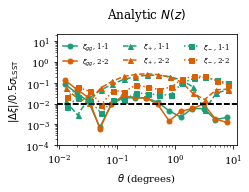

<Figure size 432x288 with 0 Axes>

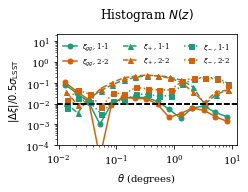

<Figure size 432x288 with 0 Axes>

In [94]:
names={'analytic':'Analytic','histo':'Histogram','dd':r'$\xi_{gg}$','ll+':r'$\xi_+$','ll-':r'$\xi_-$',
       'b1b1':'1-1','b1b2':'1-2','b2b2':'2-2','cb1b1':'r','cb1b2':'b','cb2b2':'y','cdd':'o-','cll+':'^--',
       'cll-':'s:'}

target_accuracy = 1e-2

inz=0
for nztyp in ['analytic','histo'] :
    plt.figure(figsize=fig_size)#figsize=(15,11.25))

    za=zarrs[nztyp]
    ibn=0
    for trtyp in ['dd','ll+','ll-'] :
        for i, bn in enumerate(['b1b1','b2b2']):
#                 plt.errorbar(theta_deg*(1+0.03*(ibn+inz)),np.absolute(corr_bench[nztyp][bn][trtyp]['xi']/corr[nztyp][bn][trtyp]-1),
#                              bench_err_dd[bn]/corr[nztyp][bn][trtyp]/10,fmt=names['c'+bn]+names['c'+trtyp],
#                      label=names[trtyp]+', '+names[bn])#errors are suppressed by factor of 10
                plt.plot(theta_deg*(1+0.03*(ibn+inz)),np.absolute(corr_bench[nztyp][bn][trtyp]['xi']-corr[nztyp][bn][trtyp])/bench_err[trtyp][bn],
                         c=color_map(i), marker=names['c'+trtyp][0], ms=5, ls=names['c'+trtyp][1:], 
                         label=names[trtyp]+', '+names[bn])
                
                plt.xscale('log')
                plt.yscale('log')
        plt.axhline(target_accuracy, c="k", ls="--")
#         plt.ylim(-1.e0,1.e0)
        plt.legend(ncol=3, fontsize="x-small", frameon=False)
        plt.ylim(1.e-4,22.e0)
        plt.xlabel(r'$\theta$ (degrees)')
        plt.ylabel(r'$|\Delta \xi|/0.5\sigma_{\rm LSST}$')
#         plt.text(y=0.1,x=0.01,s='clustering',fontsize=18)
        ibn+=1
    inz+=1
    plt.title(names[nztyp]+r' $N(z)$')
    plt.gcf().subplots_adjust(left=0.2)
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig('projected_correlation_error_comparison_'+nztyp+'.eps')
    plt.show()
    plt.clf()

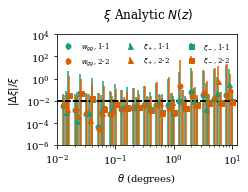

<Figure size 432x288 with 0 Axes>

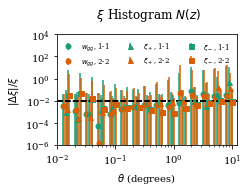

<Figure size 432x288 with 0 Axes>

In [100]:
names={'analytic':'Analytic','histo':'Histogram','dd':r'$w_{gg}$','ll+':r'$\xi_+$','ll-':r'$\xi_-$',
       'b1b1':'1-1','b1b2':'1-2','b2b2':'2-2','cb1b1':'r','cb1b2':'b','cb2b2':'y','cdd':'o','cll+':'^',
       'cll-':'s'}

target_accuracy = 1e-2

inz=0
for nztyp in ['analytic','histo'] :
    plt.figure(figsize=fig_size)#figsize=(15,11.25))
    
    za=zarrs[nztyp]
    itr=0
    for trtyp in ['dd','ll+','ll-'] :
        ibn=0
        for i, bn in enumerate(['b1b1','b2b2']):
                plt.errorbar(theta_deg*(1+0.04*(ibn+itr*3)),np.absolute(corr_bench[nztyp][bn][trtyp]['xi']/corr[nztyp][bn][trtyp]-1),
                             bench_err[trtyp][bn]/corr[nztyp][bn][trtyp]/1,
                             c=color_map(i), ls="none", marker=names['c'+trtyp], ms=5,
                     label=names[trtyp]+', '+names[bn])#errors are suppressed by factor of 10
#                 plt.plot(theta_deg*(1+0.03*(ibn+inz)),np.absolute(corr_bench[nztyp][bn][trtyp]['xi']-corr[nztyp][bn][trtyp])/bench_err[trtyp][bn],
#                          names['c'+bn]+names['c'+trtyp],label=names[trtyp]+', '+names[bn],ms=15)
                
                plt.xscale('log')
                plt.yscale('log')
                ibn+=1
        plt.axhline(target_accuracy, c="k", ls="--")
        plt.ylim(1e-6, 1e4)
        plt.xlim(1.e-2,12)
        plt.legend(ncol=3, fontsize="x-small", frameon=False)
#         plt.ylim(5.e-4,2.e0)
        plt.xlabel(r'$\theta$ (degrees)')
        plt.ylabel(r'$|\Delta \xi|/\xi$')
#         plt.text(y=0.1,x=0.01,s='clustering',fontsize=18)
        itr+=1
    inz+=1
    plt.title(r' $\xi$ '+names[nztyp]+r' $N(z)$')
    plt.gcf().subplots_adjust(left=0.2)
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig('projected_correlation_'+nztyp+'.eps')
    plt.show()
    plt.clf()

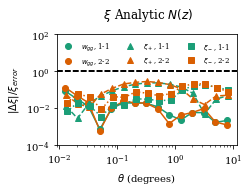

<Figure size 432x288 with 0 Axes>

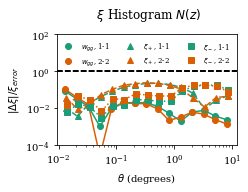

<Figure size 432x288 with 0 Axes>

In [106]:
#In this cell we plot positive and negative values with different markers.
#Negative have open marker and positive have solid markers
names={'analytic':'Analytic','histo':'Histogram','dd':r'$w_{gg}$','ll+':r'$\xi_+$','ll-':r'$\xi_-$',
       'b1b1':'1-1','b1b2':'1-2','b2b2':'2-2','cb1b1':'r','cb1b2':'b','cb2b2':'y','cdd':'o','cll+':'^',
       'cll-':'s','cdd_l':'-','cll+_l':'--',
       'cll-_l':':'}

target_accuracy = 1

ms=20
inz=0
for nztyp in ['analytic','histo'] :
    plt.figure(figsize=fig_size)#figsize=(15,11.25))
    za=zarrs[nztyp]
    ibn=0
    for trtyp in ['dd','ll+','ll-'] :
        for i, bn in enumerate(['b1b1','b2b2']):
#                 plt.errorbar(theta_deg*(1+0.03*(ibn+inz)),np.absolute(corr_bench[nztyp][bn][trtyp]['xi']/corr[nztyp][bn][trtyp]-1),
#                              bench_err_dd[bn]/corr[nztyp][bn][trtyp]/10,fmt=names['c'+bn]+names['c'+trtyp],
#                      label=names[trtyp]+', '+names[bn])#errors are suppressed by factor of 10
                diff=(corr_bench[nztyp][bn][trtyp]['xi']-corr[nztyp][bn][trtyp])/bench_err[trtyp][bn]
                x=diff>=0
                plt.plot(theta_deg[x]*(1+0.03*(ibn+inz)),(diff[x]),
                         c=color_map(i), marker=names['c'+trtyp], ls="none",
                         label=names[trtyp]+', '+names[bn])
                x=diff<0
                plt.plot(theta_deg[x]*(1+0.03*(ibn+inz)),np.absolute(diff[x]),
                         c=color_map(i), marker=names['c'+trtyp], ls="none")
                
                plt.plot(theta_deg*(1+0.03*(ibn+inz)),np.absolute(diff),
                         c=color_map(i), ls=names['c'+trtyp+'_l'],zorder=-1)
                plt.xscale('log')
                plt.yscale('log')
        plt.axhline(target_accuracy, c="k", ls="--")
#         plt.ylim(-1.e0,1.e0)
        plt.legend(ncol=3, fontsize="x-small", frameon=False)
        plt.ylim(1.e-4,1e2)
        plt.xlabel(r'$\theta$ (degrees)')
        plt.ylabel(r'$|\Delta \xi|/\xi_{{error}}$')
#         plt.text(y=0.1,x=0.01,s='clustering',fontsize=18)
        ibn+=1
    inz+=1
    plt.title(r' $\xi$ '+names[nztyp]+r' $N(z)$')
    plt.gcf().subplots_adjust(left=0.2)
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().subplots_adjust(bottom=0.2)
#     plt.savefig('projected_correlation_error_comparison_'+nztyp+'.eps')
    plt.show()
    plt.clf()

# Matter power spectrum

### Cosmological Emulator - case with no neutrinos

We first load the emulator cosmologies. Among them, we will only use models: 1,3,5,6,8,10. We will compare to CCL at z=0. The requirement is a fracional discrepancy lower than 3%. This is the tolerance we have required based on the emulator paper results (Section 3.3, Fig 6). 

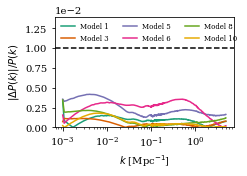

<Figure size 432x288 with 0 Axes>

In [113]:
emu_cosmo_mat=np.loadtxt('../tests/benchmark/emu_cosmologies.txt')
Omega_c_emu=emu_cosmo_mat[:,0]
Omega_b_emu=emu_cosmo_mat[:,1]
h_emu=emu_cosmo_mat[:,2]
sigma8_emu=emu_cosmo_mat[:,3]
ns_emu=emu_cosmo_mat[:,4]
w0_emu=emu_cosmo_mat[:,5]
wa_emu=emu_cosmo_mat[:,6]
models = np.array([1,3,5,6,8,10])
colvec=plt.cm.magma(np.linspace(0,0.8,len(models)))

target_accuracy = 1e-2

plt.figure(figsize=fig_size)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.gca().set_xscale('log')
for i_model in range(0,len(models)):
    params_emu=ccl.Parameters(Omega_c=Omega_c_emu[i_model], Omega_b=Omega_b_emu[i_model], h=h_emu[i_model], 
                              sigma8 = sigma8_emu[i_model], n_s=ns_emu[i_model], w0=w0_emu[i_model], wa=wa_emu[i_model],Neff=3.04)
    params_emu.parameters.Omega_l=params_emu.parameters.Omega_l+params_emu.parameters.Omega_g
    params_emu.parameters.Omega_g =0.
    cosmo_emu = ccl.Cosmology(params_emu,transfer_function='emulator',matter_power_spectrum='emu')
    pk_emu=np.loadtxt("../tests/benchmark/emu_smooth_pk_M"+str(models[i_model])+".txt")
    pk_ccl=ccl.nonlin_matter_power(cosmo_emu,pk_emu[:,0],1.)
    plt.plot(pk_emu[:,0],np.abs(pk_ccl/pk_emu[:,1]-1.),'-',color=color_map(i_model), label="Model {}".format(models[i_model]))
    
plt.legend(ncol=3, loc="upper left", fontsize="x-small", frameon=False)
plt.ylim(0, 1.4e-2)
plt.locator_params(axis="y", nbins=6)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.axhline(target_accuracy, c="k", ls="--")
plt.savefig('poweremu.eps')
plt.show()
plt.clf()

### Cosmological Emulator - with neutrinos

Similar to the case above, but for cosmologies with neutrinos.

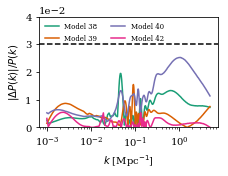

<Figure size 432x288 with 0 Axes>

In [115]:
emu_cosmo_mat=np.loadtxt('../tests/benchmark/emu_nu_cosmologies.txt')
Omega_c_emu=emu_cosmo_mat[:,0]
Omega_b_emu=emu_cosmo_mat[:,1]
h_emu=emu_cosmo_mat[:,2]
sigma8_emu=emu_cosmo_mat[:,3]
ns_emu=emu_cosmo_mat[:,4]
w0_emu=emu_cosmo_mat[:,5]
wa_emu=emu_cosmo_mat[:,6]
Omega_nu_emu=emu_cosmo_mat[:,7]
models = np.array([38,39,40,42])
colvec=plt.cm.magma(np.linspace(0,0.8,len(models)))


target_accuracy = 3e-2

plt.figure(figsize=fig_size)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.gca().set_xscale('log')
for i_model in range(0,len(models)):
    #Figure out the neutrino mass for this Omega_nu:
    Mnu_out = ccl.nu_masses(Omega_nu_emu[i_model]*h_emu[i_model]**2, 'equal', 2.725)
    params_emu=ccl.Parameters(Omega_c=Omega_c_emu[i_model], Omega_b=Omega_b_emu[i_model], h=h_emu[i_model], 
                              sigma8 = sigma8_emu[i_model],m_nu=Mnu_out, n_s=ns_emu[i_model], w0=w0_emu[i_model], 
                              wa=wa_emu[i_model],Neff=3.04)
    params_emu.parameters.Omega_l=params_emu.parameters.Omega_l+params_emu.parameters.Omega_g
    params_emu.parameters.Omega_g =0.
    cosmo_emu = ccl.Cosmology(params_emu,transfer_function='emulator',matter_power_spectrum='emu')
    pk_emu=np.loadtxt("../tests/benchmark/emu_nu_smooth_pk_M"+str(models[i_model])+".txt")
    pk_ccl=ccl.nonlin_matter_power(cosmo_emu,pk_emu[:,0],1.)
    plt.plot(pk_emu[:,0],np.abs(pk_ccl/pk_emu[:,1]-1.),'-',color=color_map(i_model), label="Model {}".format(models[i_model]))
    
plt.legend(ncol=2, loc="upper left", fontsize="x-small", frameon=False)
plt.ylim(0, 4e-2)
plt.locator_params(axis="y", nbins=6)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.axhline(target_accuracy, c="k", ls="--")

plt.savefig('poweremu_nu.eps')
plt.show()
plt.clf()

### Baryonic correction model
Test that we have implemented this model correctly. The tolerance is 1E-4.

Max diff for BCM= 8.452127886471317e-13


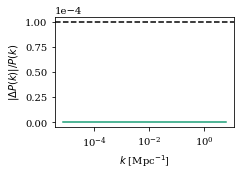

<Figure size 432x288 with 0 Axes>

In [116]:
params_bar=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.2e-9, n_s=0.96, Neff=3.046,bcm_log10Mc=14.)
params_nobar=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.2e-9, n_s=0.96, Neff=3.046)
params_bar.parameters.Omega_l=params_bar.parameters.Omega_l+params_bar.parameters.Omega_g
params_bar.parameters.Omega_g =0.
params_nobar.parameters.Omega_l=params_nobar.parameters.Omega_l+params_nobar.parameters.Omega_g
params_nobar.parameters.Omega_g =0.
cosmo_nobar = ccl.Cosmology(params_nobar)
cosmo_bar = ccl.Cosmology(params_bar,baryons_power_spectrum='bcm')

pk_bench_bar=np.loadtxt('../tests/benchmark/bcm/w_baryonspk_nl.dat')
pk_bench_nobar=np.loadtxt('../tests/benchmark/bcm/wo_baryonspk_nl.dat')

pk_ccl_bar=ccl.nonlin_matter_power(cosmo_bar,pk_bench_bar[:,0]*0.7,1.)
pk_ccl_nobar=ccl.nonlin_matter_power(cosmo_nobar,pk_bench_bar[:,0]*0.7,1.)

target_accuracy = 1e-4

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gca().set_xscale('log')
plt.plot(pk_bench_bar[:,0]*0.7,np.abs(pk_ccl_bar/pk_ccl_nobar/(pk_bench_bar[:,1]/pk_bench_nobar[:,1])-1.),
         '-',color=color_map(0))
print("Max diff for BCM=",np.max(np.abs(pk_ccl_bar/pk_ccl_nobar/(pk_bench_bar[:,1]/pk_bench_nobar[:,1])-1.)))
plt.axhline(target_accuracy, c="k", ls="--")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))

plt.savefig('bcm.eps')
plt.show()
plt.clf()

### Matter power spectrum from CLASS with massive neutrinos
This test compares the matter power spectrum in cosmologies with massive neutrinos computed using CLASS and called using CCL to that computed via CLASS externally. This is simply intended to check that we are setting up massive neutrino parameters correctly and passing parameters correctly to CLASS, not to test the P(k) computation itself.

First, set up the cosmologies we use here.

In [117]:
params_cclmnu1_pk=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, Neff=3.046, m_nu=[0.04, 0., 0.])
cosmo_cclmnu1_pk = ccl.Cosmology(params_cclmnu1_pk)
params_cclmnu2_pk=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, Neff=3.046, m_nu=[0.05, 0.01, 0.])
cosmo_cclmnu2_pk = ccl.Cosmology(params_cclmnu2_pk)
params_cclmnu3_pk=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1, Neff=3.046, m_nu=[0.03, 0.02, 0.04])
cosmo_cclmnu3_pk = ccl.Cosmology(params_cclmnu3_pk)

cosmo_mnu_pk_list=[cosmo_cclmnu1_pk,cosmo_cclmnu2_pk,cosmo_cclmnu3_pk]
num_models_mnu_pk = 3;

Next, load the benchmarks for the linear and nonlinear matter power spectrum (computed using CLASS externally).

In [118]:
lin_k_pk = [np.loadtxt("../tests/benchmark/model"+str(mi+1)+"_pk_nu.txt", unpack=True) for mi in range(num_models_mnu_pk)]
nl_k_pk = [np.loadtxt("../tests/benchmark/model"+str(mi+1)+"_pk_nl_nu.txt", unpack=True) for mi in range(num_models_mnu_pk)]

Plot the difference for the linear matter power spectrum

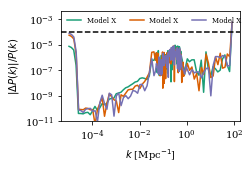

<Figure size 432x288 with 0 Axes>

In [134]:
colvec=plt.cm.magma(np.linspace(0,0.8,num_models_mnu_pk))

target_accuracy = 1e-4

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gca().set_xscale('log')
for i_model in range(0,num_models_mnu_pk):
    pk_lin_ccl=ccl.linear_matter_power(cosmo_mnu_pk_list[i_model],lin_k_pk[i_model][0] * cosmo_mnu_pk_list[i_model]['h'],1.) * (cosmo_mnu_pk_list[i_model]['h'])**3
    plt.plot(lin_k_pk[i_model][0],np.abs(pk_lin_ccl/lin_k_pk[i_model][1]-1.),
             ls='-', color=color_map(i_model), label="Model X")
    
plt.yscale("log")
plt.legend(ncol=3, loc="upper left", fontsize="x-small", frameon=False)
plt.ylim(1e-11, 5e-3)
# plt.locator_params(axis="y", nbins=6)
# plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.axhline(target_accuracy, c="k", ls="--")
plt.savefig('pk_class_nu.eps')
plt.show()
plt.clf()

And for the nonlinear matter power spectrum

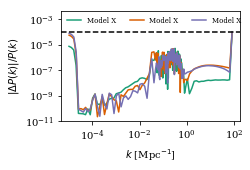

<Figure size 432x288 with 0 Axes>

In [132]:
colvec=plt.cm.magma(np.linspace(0,0.8,num_models_mnu_pk))

target_accuracy = 1e-4

plt.figure(figsize=fig_size)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.gca().set_xscale('log')
for i_model in range(0,num_models_mnu_pk):
    pk_nl_ccl=ccl.nonlin_matter_power(cosmo_mnu_pk_list[i_model],lin_k_pk[i_model][0] * cosmo_mnu_pk_list[i_model]['h'],1.) * (cosmo_mnu_pk_list[i_model]['h'])**3
    plt.plot(nl_k_pk[i_model][0],np.abs(pk_nl_ccl/nl_k_pk[i_model][1]-1.),
             ls='-', color=color_map(i_model), label="Model X")
    
plt.yscale("log")
plt.legend(ncol=3, loc="upper left", fontsize="x-small", frameon=False)
plt.ylim(1e-11, 5e-3)
# plt.locator_params(axis="y", nbins=6)
# plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.axhline(target_accuracy, c="k", ls="--")
plt.savefig('pk_class_nu_NL.eps')
plt.show()
plt.clf()

The small and large wavenumber excess is produced by our extrapolation schemes for the power spectrum spines. In the case with neutrinos, the result is an accuracy of 1E-3.

## Mass function

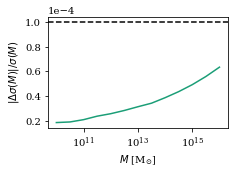

<Figure size 432x288 with 0 Axes>

In [137]:
bench=np.loadtxt('../tests/benchmark/model1_hmf.txt')
log10mass = bench[0:,0]
sigma = bench[0:,1]
log10invsigma = bench[0:,2]
log10massfunc = bench[0:,3]

scale_fact = 1.

# setting up different cosmology configuration to match benchmarks and keep CLASS from crashing.
params_ccl1_mf=ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96)
params_ccl1_mf.parameters.Omega_g =0.
params_ccl1_mf.parameters.Omega_l =0.7
params_ccl1_mf.parameters.sigma_8 =0.8
#Only now that parameters are correct we can set up the cosmology
cosmo_ccl1_mf = ccl.Cosmology(params_ccl1_mf, transfer_function='bbks', mass_function='tinker')

target_accuracy = 1e-4

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.ylabel(r'$|\Delta \sigma(M)|/\sigma(M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.gca().set_xscale('log')
plt.plot(10**log10mass, np.abs(ccl.sigmaM(cosmo_ccl1_mf,10**log10mass,scale_fact)/sigma-1),
        c=color_map(0))
plt.axhline(target_accuracy, c="k", ls="--")
# plt.locator_params(axis="y", nbins=6)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.savefig('hmf_model1.eps')
plt.show()
plt.clf()

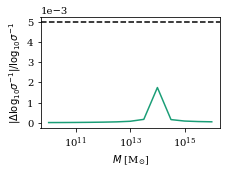

<Figure size 432x288 with 0 Axes>

In [140]:
# strange spike in this demanded reduction of total accuracy. Since sigmaM matches well, we didn't worry about it too much.
# inaccuracy in halo mass function potentially much higher.

target_accuracy = 5e-3

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.ylabel(r'$|\Delta \log_{10}\sigma^{-1}|/\log_{10}\sigma^{-1}$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.gca().set_xscale('log')
plt.plot(10**log10mass, np.abs(np.log10(1./ccl.sigmaM(cosmo_ccl1_mf,10**log10mass,scale_fact))/log10invsigma-1),
        c=color_map(0))
plt.axhline(target_accuracy, c="k", ls="--")
plt.locator_params(axis="y", nbins=6)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.savefig('hmf_model1_b.eps')
plt.show()
plt.clf()

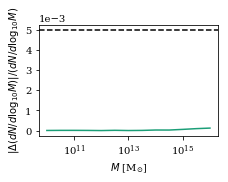

<Figure size 432x288 with 0 Axes>

In [141]:
# we currently have listed 5e-3 accuracy as our target, but clearly much better fit here. The spike in our inverse
# sigma spline is not that impactful here.

rho_m = ccl.constants.RHO_CRITICAL*cosmo_ccl1_mf.params.parameters.Omega_m*cosmo_ccl1_mf.params.parameters.h**2
logmassfunc_test = np.log10(ccl.massfunc(cosmo_ccl1_mf, 10**log10mass, scale_fact)*(10**log10mass)/rho_m/np.log(10))

target_accuracy = 5e-3

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.ylabel(r'$|\Delta (dN/d\log_{10}M)|/(dN/d\log_{10}M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.gca().set_xscale('log')
plt.plot(10**log10mass, np.abs(logmassfunc_test/log10massfunc-1),
        c=color_map(0))
plt.axhline(target_accuracy, c="k", ls="--")
plt.locator_params(axis="y", nbins=6)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.savefig('hmf_model1_c.eps')
plt.show()
plt.clf()

## 3d correlation

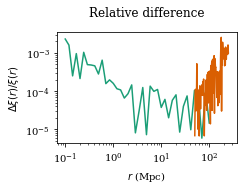

<Figure size 432x288 with 0 Axes>

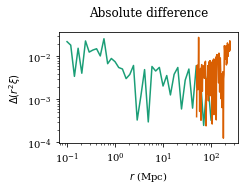

<Figure size 432x288 with 0 Axes>

In [143]:
p1 = ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.80, n_s=0.96, w0=-1.0, wa=0.0)
p2 = ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.80, n_s=0.96, w0=-0.9, wa=0.0)
p3 = ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.80, n_s=0.96, w0=-0.9, wa=0.1)
p1.parameters.Omega_g = 0
p2.parameters.Omega_g = 0
p3.parameters.Omega_g = 0

# define the cosmology model to use
cosmo = ccl.Cosmology(p1)

# read in the benchmark xi values for each redshift z
bench = np.loadtxt('../tests/benchmark/model1_xi.txt')
d_bench = bench[0:,0:]

xi = []
for z in range(6): 
    xi.append(d_bench[0:,z+1])
xi_bench = np.asarray(xi)

# calculate CCL xi for r = 0.1 - 100 with 40 bins
nr1 = 40
r1 = np.logspace(-1, 2, nr1)
xi1 = []
for z in range(6):
    xi1.append(ccl.correlation_3d(cosmo, 1./(z+1), r1))

# calculate CCL xi for r = 50 - 250 with 100 bins to check agreement in the BAO peak region
nr2 = 100
r2 = np.logspace(np.log10(50), np.log10(250), nr2)
xi2 = []
for z in range(6):
    xi2.append(ccl.correlation_3d(cosmo, 1./(z+1), r2))

# Define redshift value and make plots
z = 0   

# Plot relative difference
frac_diff1 = []
frac_diff2 = []
abs_diff1 = []    
abs_diff2 = []

for i in range(nr1):
    frac_diff1.append(np.abs(xi1[z][i]/xi_bench[z][i] - 1.))
    abs_diff1.append(np.abs(r1[i]*r1[i]*(xi1[z][i]-xi_bench[z][i])))
    
for i in range(nr2):
    frac_diff2.append(np.abs(1-xi2[z][i]/xi_bench[z][i+40]))
    abs_diff2.append(np.abs(r2[i]*r2[i]*(xi2[z][i]-xi_bench[z][i+40])))

# # esthetic definitions for the plots
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.rcParams['font.size'] = 14

plt.figure(figsize=fig_size)
plt.plot(r1, frac_diff1, '-', c=color_map(0))
plt.plot(r2, frac_diff2, '-', c=color_map(1))
plt.xscale('log')
plt.yscale('log')
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.xlabel(r'$r$ (Mpc)')
plt.ylabel(r'$\Delta \xi(r) / \xi(r)$')
# plt.grid(which='major')
plt.title('Relative difference') 
plt.savefig('benchmark_rel.pdf')
plt.show()
plt.clf()

# plot absolute difference in r^2 xi(r)
plt.figure(figsize=fig_size)
plt.plot(r1, abs_diff1, c=color_map(0))
plt.plot(r2, abs_diff2, c=color_map(1))
plt.xscale('log')
plt.yscale('log')
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.xlabel(r'$r$ (Mpc)')
plt.ylabel(r'$\Delta (r^2 \xi) $')
# plt.grid(which='minor')
plt.title('Absolute difference') 
# plt.grid(which='both')
plt.savefig('benchmark_abs.pdf')
plt.show()
plt.clf()


### Compare CCL transform with known transform of an analytic function 

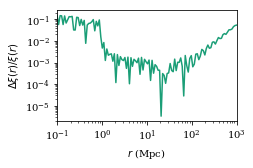

<Figure size 432x288 with 0 Axes>

In [144]:
# read 3d correlation analytuic benchmark test data and plot

bench_analytic = np.loadtxt('analytic_xi.txt')
r = bench_analytic[:,0]
diff = bench_analytic[:,1]
plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().subplots_adjust(bottom=0.2)
plt.xlabel(r'$r$ (Mpc)')
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.1,1000.))
plt.ylabel(r'$\Delta \xi(r)/\xi(r)$')
# plt.grid()
plt.plot(r, diff, c=color_map(0))
plt.savefig('3dcorr_analytic.eps')
plt.show()
plt.clf()

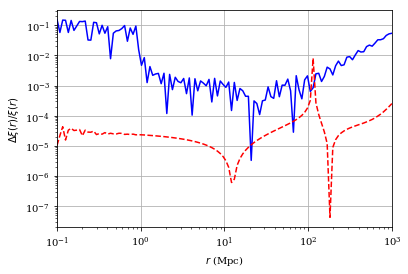

In [8]:
# read 3d correlation analytuic benchmark test data and plot

bench_analytic = np.loadtxt('analytic_xi_1.txt')
r = bench_analytic[:,0]
diff = bench_analytic[:,1]

bench_analytic2 = np.loadtxt('analytic_xi_2.txt')
#r = bench_analytic[:,0]
diff2 = bench_analytic2[:,1]


plt.xscale('log')
plt.yscale('log')
plt.xlim((0.1,1000.))
plt.xlabel(r'$r$ (Mpc)')
plt.ylabel(r'$\Delta \xi(r)/\xi(r)$')
plt.grid()
plt.plot(r, diff, 'b-')
plt.plot(r, diff2, 'r--')
plt.show()